In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src
from src.paleoseismic import PaleoseismicCatalog
import os
from pathlib import Path
import yaml
from adjustText import adjust_text
import cartopy.crs as ccrs

plt.style.use('tableau-colorblind10')
base_dir = Path(src.__file__).parents[1]
data_directory = base_dir/"data"
restults_directory = base_dir/"results"/"manuscript"

In [7]:
data_files = [
    f for f in os.listdir(data_directory / "trench_records") if f.endswith(".txt")
]

with open(data_directory / "metadata.yaml", "r") as f:
    meta_data = yaml.safe_load(f)

# Create a dictionary mapping regions to the list of indices for data_files
fault_to_indices = {}
for idx, f in enumerate(data_files):
    fault = meta_data[f]["fault"]
    if fault not in fault_to_indices:
        fault_to_indices[fault] = []
    fault_to_indices[fault].append(idx)

# Optionally, create a list of lists: each inner list contains indices for a region

region_order = [
    "San Andreas Fault",
    "San Jacinto Fault",
    "Cascadia",
    "Central Cascadia",
    "Altyn Tagh Fault",
    "Dead Sea Fault",
    "Alpine Fault",
]

fault_indices_list = np.concatenate(list(
    [
        fault_to_indices[fault] 
        for fault in region_order
    ]
))

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_90517/1769948739.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


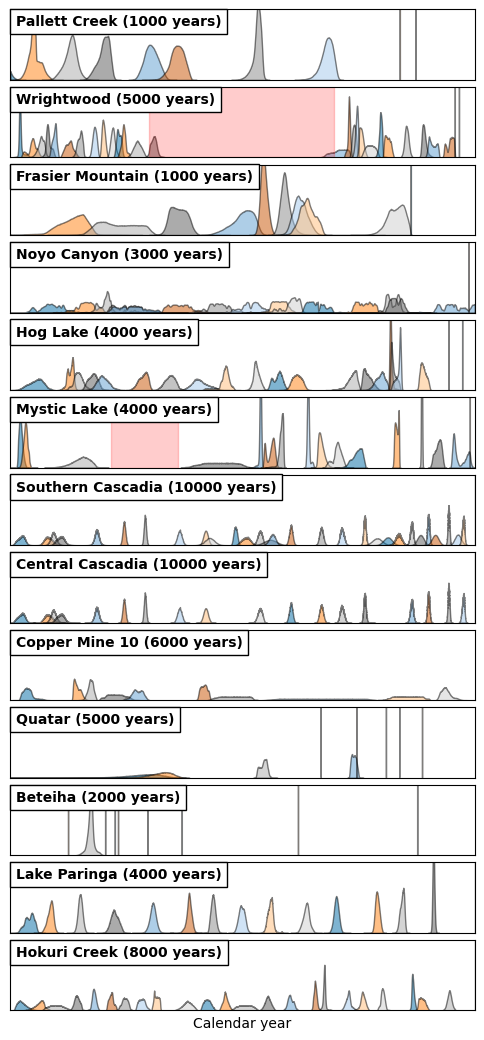

In [ ]:
# read in the files
fig, AX = plt.subplots(len(data_files), 1, figsize=(6, len(data_files) * 1), dpi=100, gridspec_kw=dict(hspace=0.1))

for i_fault, ax in zip(fault_indices_list, AX):
    trench_catalog = PaleoseismicCatalog(
        file=data_directory / "trench_records" / data_files[i_fault],
        **meta_data[data_files[i_fault]],
    )
    
    ax = trench_catalog.plot_pdfs(ax=ax)
    
    def round_to_one_sig_fig(x):
        return np.round(x, -int(np.floor(np.log10(x))))
    
    ax.text(
        0.013,
        0.825,
        f"{trench_catalog.name} ({round_to_one_sig_fig(trench_catalog.end_time - trench_catalog.start_time):0.0f} years)",
        fontsize=10,
        transform=ax.transAxes,
        ha="left",
        va="center",
        bbox=dict(facecolor="white", edgecolor="k", alpha=1),
        fontweight="bold",
    )

    ax.set(
        xlabel="",
        ylabel="",
        yticks=[],
        ylim=(0, 0.04),
        xticks=[],
    )

ax.set_xlabel("Calendar year")

plt.tight_layout()


    

plt.savefig(restults_directory/"ages.pdf", dpi=300)

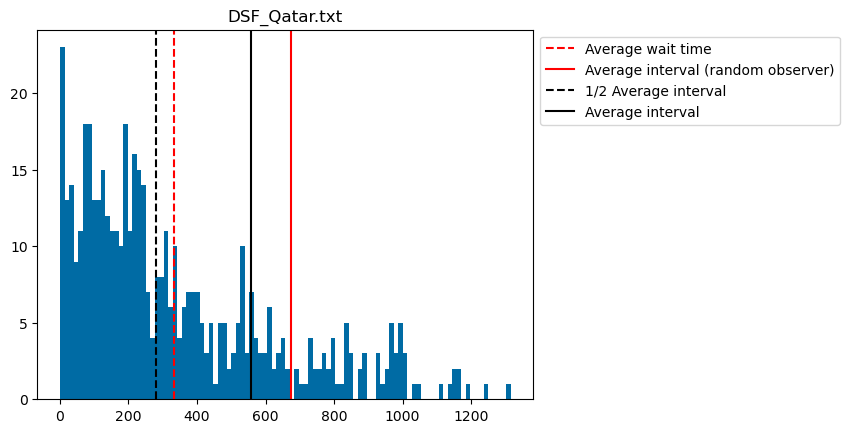

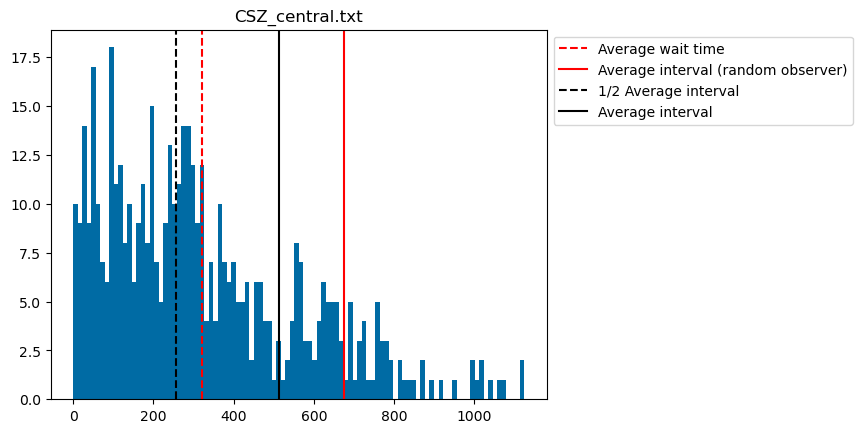

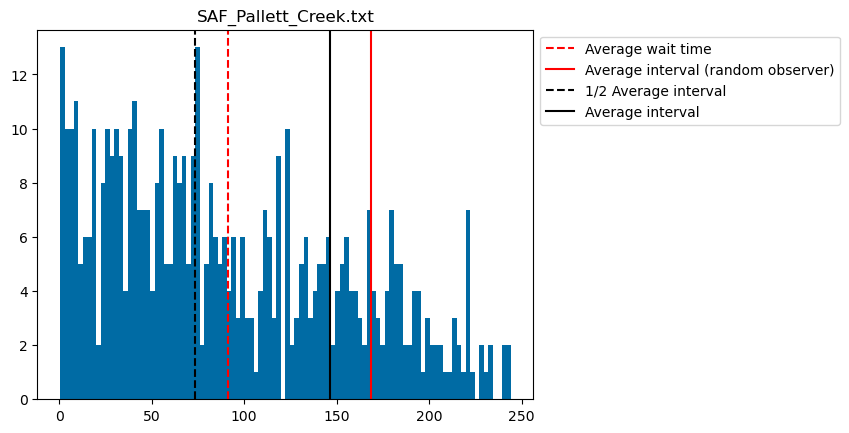

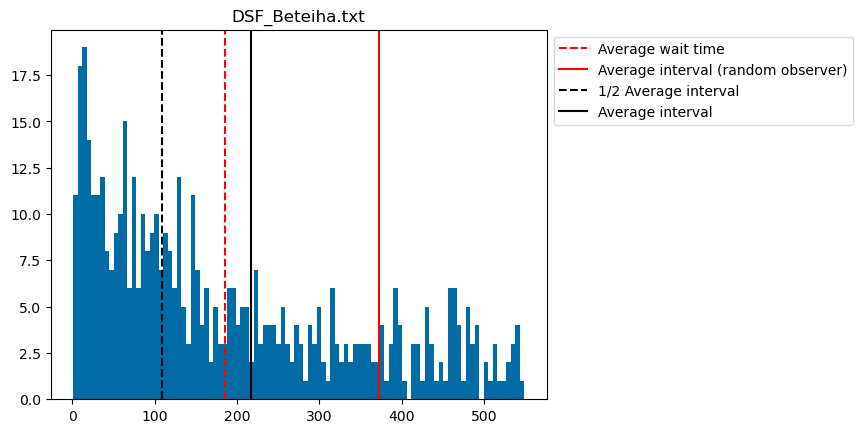

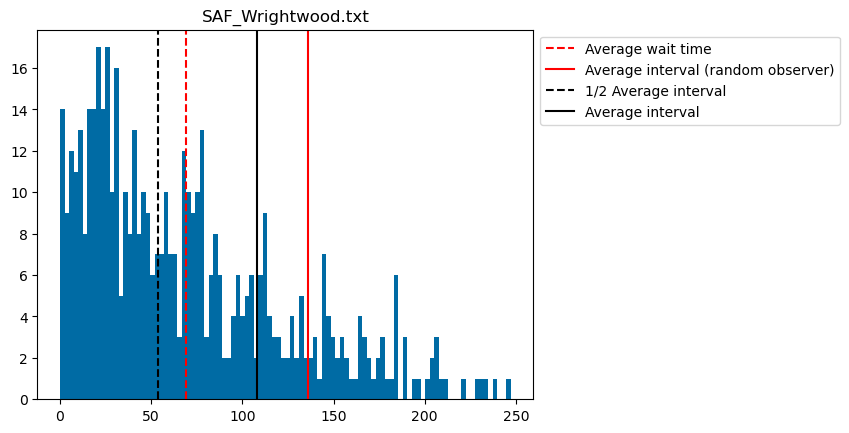

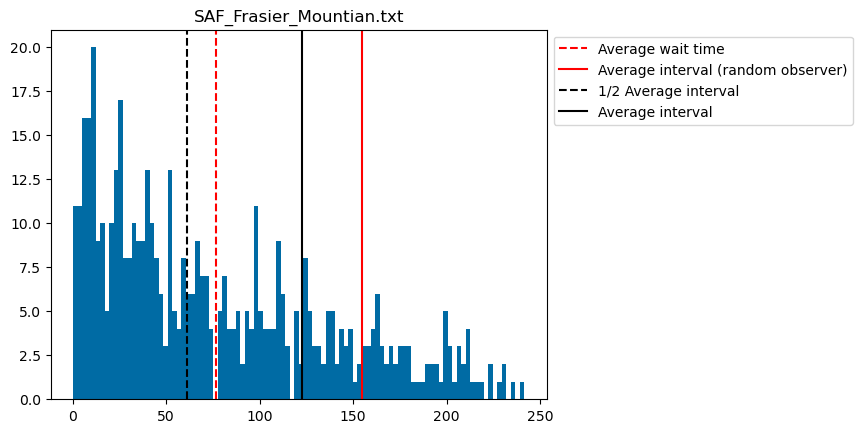

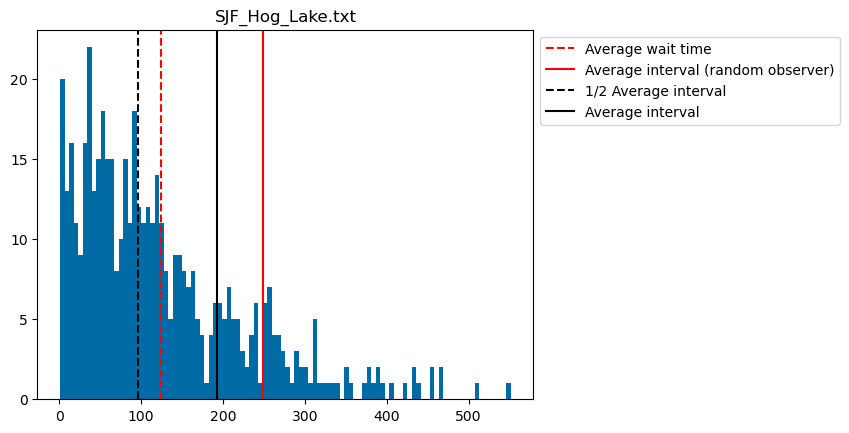

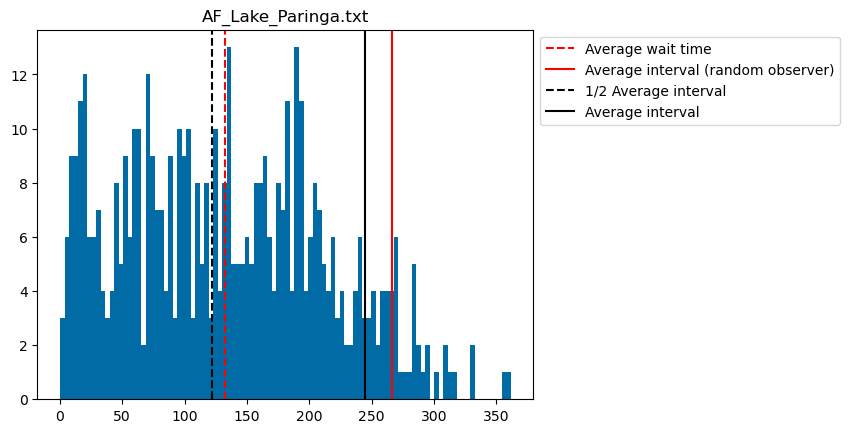

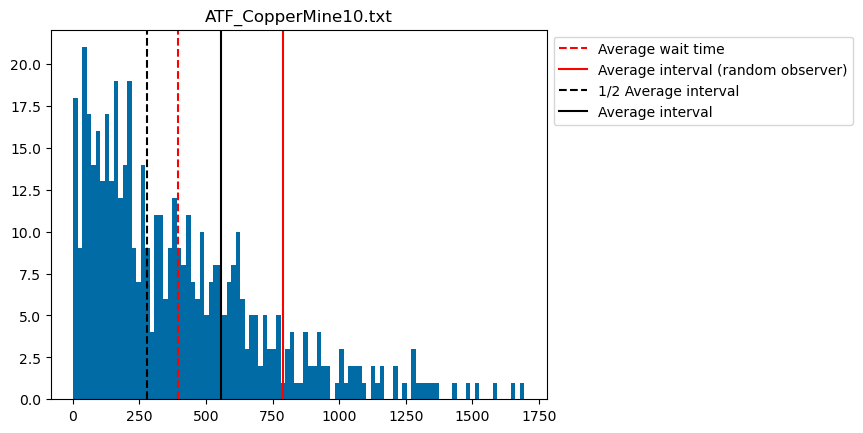

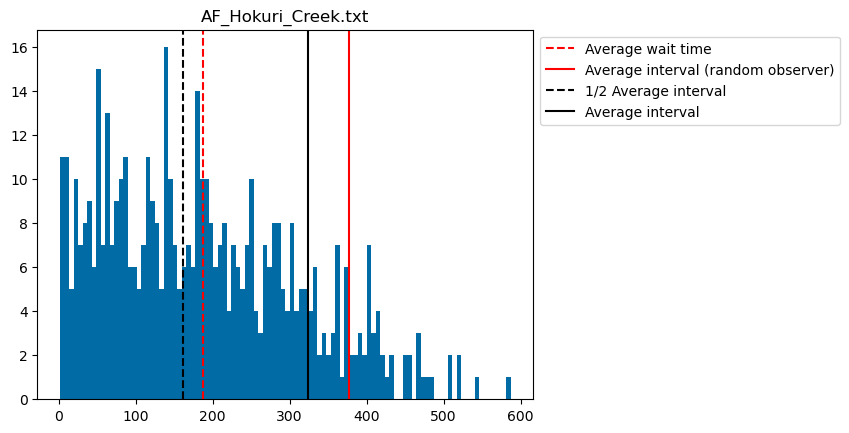

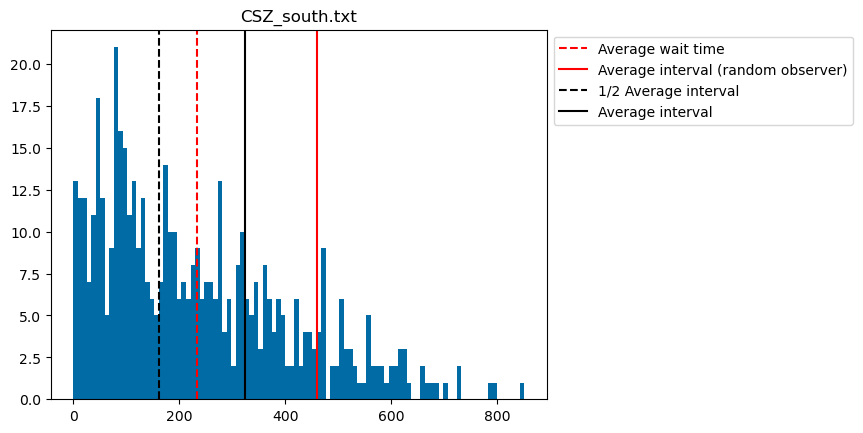

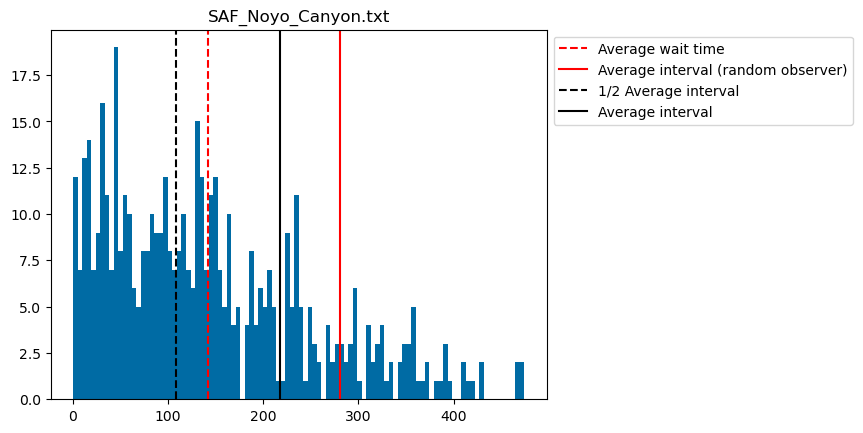

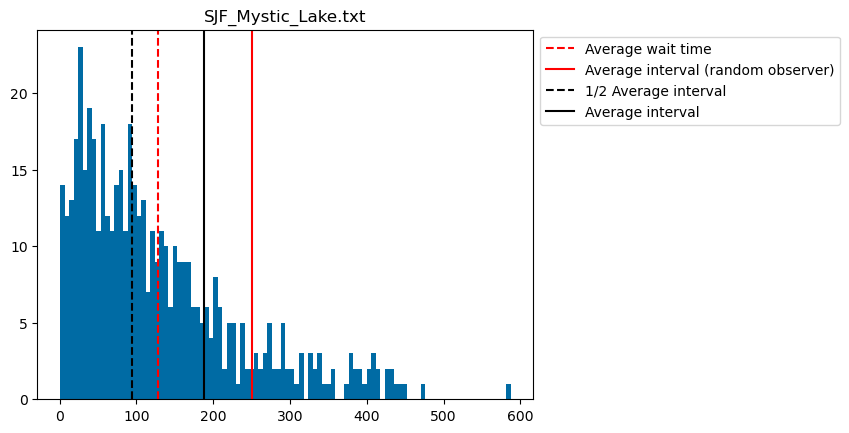

In [4]:
expected_waiting_time = []
expected_lapse_time = []
average_interval = []

COV_list = []
BIAS_list = []

for file in data_files:
    trench_catalog = PaleoseismicCatalog(
        file=data_directory / "trench_records" / file,
        **meta_data[file],
    )
    ax, waiting_time, lapse_time = trench_catalog.visualize_waiting_time(
        number_of_samples=500
    )
    ax.set_title(file)
    expected_waiting_time.append(np.nanmean(waiting_time))
    expected_lapse_time.append(np.nanmean(lapse_time))
    average_interval.append(trench_catalog.average_interval)

    BIAS_list.append(np.array(waiting_time) / trench_catalog.average_interval)

    COV_list.append(
        [
            trench_catalog.COV(
                trench_catalog.get_interevent_times(trench_catalog.sample())
            )
            for _ in range(100)
        ]
    )

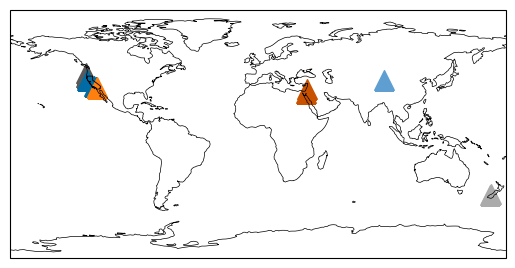

In [5]:
data_dir = Path(src.__file__).parent.parent / "data"
qfaults = src.qfaults.Qfaults(data_dir=Path(data_dir) / "Qfaults_GIS")
ax = qfaults.plot_basemap(bounds=[-180, 180, -90, 90])

keys = [
    "SAF",
    "SJF",
    "AF",
    "CSZ",
    "ATF",
    "DSF",
]

color_key = {k: f"C{i}" for i, k in enumerate(keys)}

text_h = []
for file in data_files:
    lat = meta_data[file]["latitude"]
    lon = meta_data[file]["longitude"]
    ax.scatter(lon, lat, c=color_key[file.split("_")[0]], s=200, marker="^")

plt.savefig(restults_directory/"trench_locations.pdf", dpi=300)

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_90517/1286273887.py:18: RuntimeWarning: Mean of empty slice
  ax.scatter(np.nanmean(COV), dt / T, c=color_key[key])


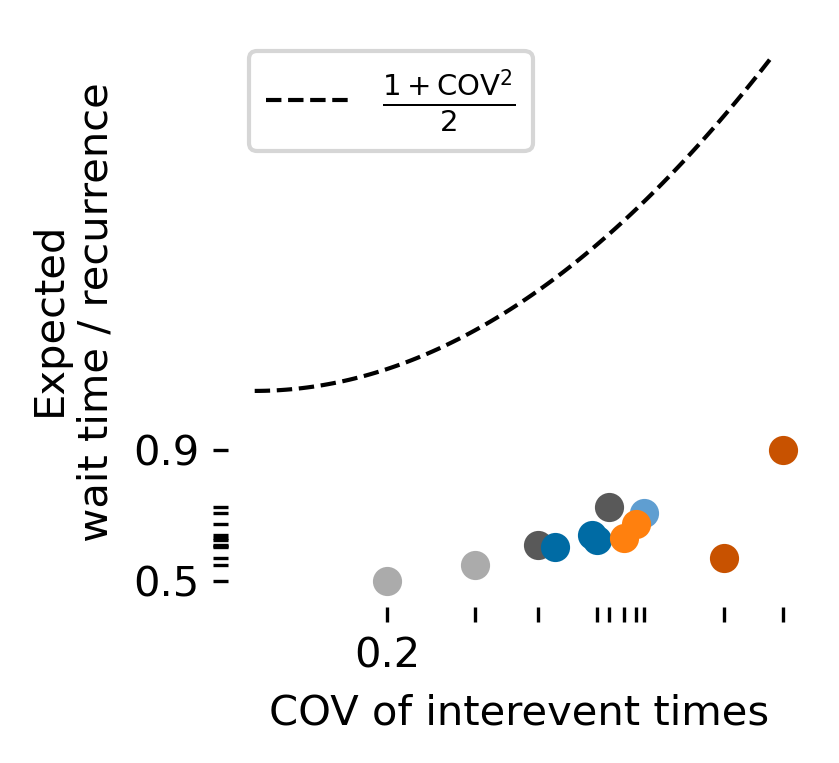

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=300)

keys = [
    "SAF",
    "SJF",
    "AF",
    "CSZ",
    "ATF",
    "DSF",
]

color_key = {k: f"C{i}" for i, k in enumerate(keys)}

for dt, T, fn, COV in zip(
    expected_waiting_time, average_interval, data_files, COV_list
):
    key = fn.split("_")[0]
    ax.scatter(np.nanmean(COV), dt / T, c=color_key[key])

cov_array = np.linspace(0, 0.9, 100)

def bias(cov):
    return (1 + cov**2)

ax.plot(
    cov_array,
    bias(cov_array),
    c="k",
    ls="--",
    lw=1,
    label=r"$\frac{1 + \text{COV}^2}{2}$",
)

yticks = np.sort(np.array(expected_waiting_time) / np.array(average_interval))
xticks = np.sort([np.mean(i_cov) for i_cov in COV_list])
ax.set(
    yticks=yticks,
    yticklabels=[
        f"{t:.1f}" if i == 0 or i == len(yticks) - 1 else ""
        for i, t in enumerate(yticks)
    ],
    xticks=xticks,
    xticklabels=[
        f"{t:.1f}" if i == 0 or i == len(xticks) - 3 else ""
        for i, t in enumerate(xticks)
    ],
    xlabel="COV of interevent times",
    ylabel="Expected\n wait time / recurrence",
)

ax.legend(
    loc="upper left",
)

# remove left, top and right spines
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

plt.savefig(restults_directory/"aggregate_analysis.pdf", dpi=300)